# Micro Analysis

Importing necessary libraries

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & pipelines
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Models & metrics
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay
)

**Data Loading**

In [29]:
df = pd.read_csv("C:\\Users\\shrey\\Downloads\\micro_gait_data (2).csv")
df

,subject,condition,replication,leg,joint,time,angle,vel,acc
0,1,1,1,1,1,0,4.682881,0.390246,-0.233599
1,1,1,1,1,1,1,5.073127,0.390246,-0.233599
2,1,1,1,1,1,2,5.229774,0.156647,-0.233599
3,1,1,1,1,1,3,5.083273,-0.146502,-0.303149
4,1,1,1,1,1,4,4.652399,-0.430874,-0.284372
...,...,...,...,...,...,...,...,...,...
181795,10,3,10,2,3,96,29.778412,-0.578100,-0.004649
181796,10,3,10,2,3,97,29.247559,-0.530853,0.047247
181797,10,3,10,2,3,98,28.796951,-0.450608,0.080246
181798,10,3,10,2,3,99,28.432936,-0.364015,0.086592


# Feature Engineering

In [30]:
df['jerk'] = df['acc'].diff()
df['jerk'] = df['jerk'].interpolate(method='linear', limit_direction='both')
df['jerk'].fillna(0, inplace=True)
df

C:\Users\shrey\AppData\Local\Temp\ipykernel_27220\978645638.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['jerk'].fillna(0, inplace=True)


,subject,condition,replication,leg,joint,time,angle,vel,acc,jerk
0,1,1,1,1,1,0,4.682881,0.390246,-0.233599,0.000000
1,1,1,1,1,1,1,5.073127,0.390246,-0.233599,0.000000
2,1,1,1,1,1,2,5.229774,0.156647,-0.233599,0.000000
3,1,1,1,1,1,3,5.083273,-0.146502,-0.303149,-0.069549
4,1,1,1,1,1,4,4.652399,-0.430874,-0.284372,0.018776
...,...,...,...,...,...,...,...,...,...,...
181795,10,3,10,2,3,96,29.778412,-0.578100,-0.004649,0.057569
181796,10,3,10,2,3,97,29.247559,-0.530853,0.047247,0.051896
181797,10,3,10,2,3,98,28.796951,-0.450608,0.080246,0.032999
181798,10,3,10,2,3,99,28.432936,-0.364015,0.086592,0.006347


In [31]:
print(df.describe().T[['mean','std','min','max']]) #For understanding

                  mean        std        min         max
subject       5.500000   2.872289   1.000000   10.000000
condition     2.000000   0.816499   1.000000    3.000000
replication   5.500000   2.872289   1.000000   10.000000
leg           1.500000   0.500001   1.000000    2.000000
joint         2.000000   0.816499   1.000000    3.000000
time         50.000000  29.154840   0.000000  100.000000
angle        12.149321  16.025823 -27.004634   78.309342
vel          -0.000616   1.294797  -5.812411    4.784986
acc           0.000922   0.212953  -0.741962    1.467331
jerk          0.000002   0.073375  -0.497319    0.525064


In [32]:
print(df.groupby('subject')[['condition', 'replication', 'leg', 'joint']].nunique())
eps = 1e-6

         condition  replication  leg  joint
subject                                    
1                3           10    2      3
2                3           10    2      3
3                3           10    2      3
4                3           10    2      3
5                3           10    2      3
6                3           10    2      3
7                3           10    2      3
8                3           10    2      3
9                3           10    2      3
10               3           10    2      3


**Calculating Stability, Symmetry and Gait score**

In [33]:
left = df[df['leg'] == 1].copy()
right = df[df['leg'] == 2].copy()

merged = pd.merge(
    left, right,
    on=['subject', 'condition', 'replication', 'joint', 'time'],
    suffixes=('_L', '_R'),
    how='inner'
)

merged['symmetry_index'] = 1 - (
    abs(merged['angle_L'] - merged['angle_R']) /
    (abs(merged['angle_L']) + abs(merged['angle_R']) + eps)
)

stability = (
    df.groupby(['subject', 'condition', 'replication', 'joint'])
      .agg(std_angle=('angle', 'std'),
           mean_abs_angle=('angle', lambda x: np.mean(np.abs(x))))
      .reset_index()
)
stability['stability_score'] = 1 - (
    stability['std_angle'] / (stability['mean_abs_angle'] + eps)
)

merged = pd.merge(
    merged,
    stability[['subject', 'condition', 'replication', 'joint', 'stability_score']],
    on=['subject', 'condition', 'replication', 'joint'],
    how='left'
)

merged['gait_score'] = 50 * merged['symmetry_index'] + 50 * merged['stability_score']

merged_clean = merged[[
    'subject', 'condition', 'replication', 'joint', 'time',
    'symmetry_index', 'stability_score', 'gait_score'
]]


df = df.merge(
    merged_clean,
    on=['subject', 'condition', 'replication', 'joint', 'time'],
    how='left'
)

print("Gait Score, Symmetry Index, and Stability Score computed successfully!")
print(df[['subject', 'condition', 'replication', 'leg', 'joint', 'time',
          'symmetry_index', 'stability_score', 'gait_score']].head(12))

Gait Score, Symmetry Index, and Stability Score computed successfully!
    subject  condition  replication  leg  joint  time  symmetry_index  \
0         1          1            1    1      1     0        0.965671   
1         1          1            1    1      1     1        0.978959   
2         1          1            1    1      1     2        0.983012   
3         1          1            1    1      1     3        0.981905   
4         1          1            1    1      1     4        0.982914   
5         1          1            1    1      1     5        0.997164   
6         1          1            1    1      1     6        0.957846   
7         1          1            1    1      1     7        0.856524   
8         1          1            1    1      1     8        0.680178   
9         1          1            1    1      1     9        0.476119   
10        1          1            1    1      1    10        0.369003   
11        1          1            1    1      1    11

# EDA and Visual Presentations 

In [34]:
def plot_subject(subj, cond, rep=1, leg=1):
    subset = df[
        (df['subject'] == subj) &
        (df['condition'] == cond) &
        (df['replication'] == rep) &
        (df['leg'] == leg)
    ]
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    cols = ['angle', 'vel', 'acc', 'jerk']
    for i, col in enumerate(cols):
        for j in sorted(subset['joint'].unique()):
            temp = subset[subset['joint'] == j]
            axes[i].plot(temp['time'], temp[col], label=f'Joint {j}', linewidth=1.5)
        axes[i].set_title(f"{col.capitalize()} vs Time (All 3 Joints)")
        axes[i].set_xlabel("Time (frames)")
        axes[i].set_ylabel(col)
        axes[i].grid(True)
        axes[i].legend()
    plt.suptitle(f"Subject {subj} | Condition {cond} | Replication {rep} | Leg {leg}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

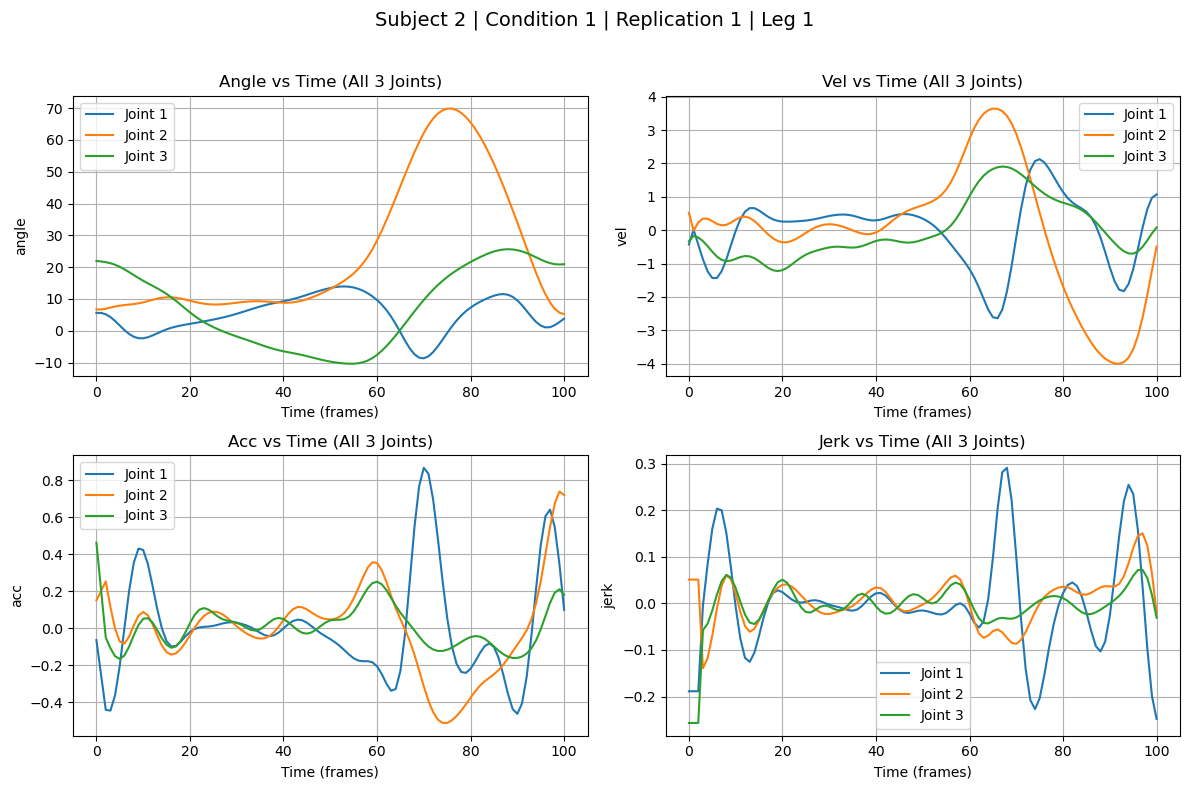

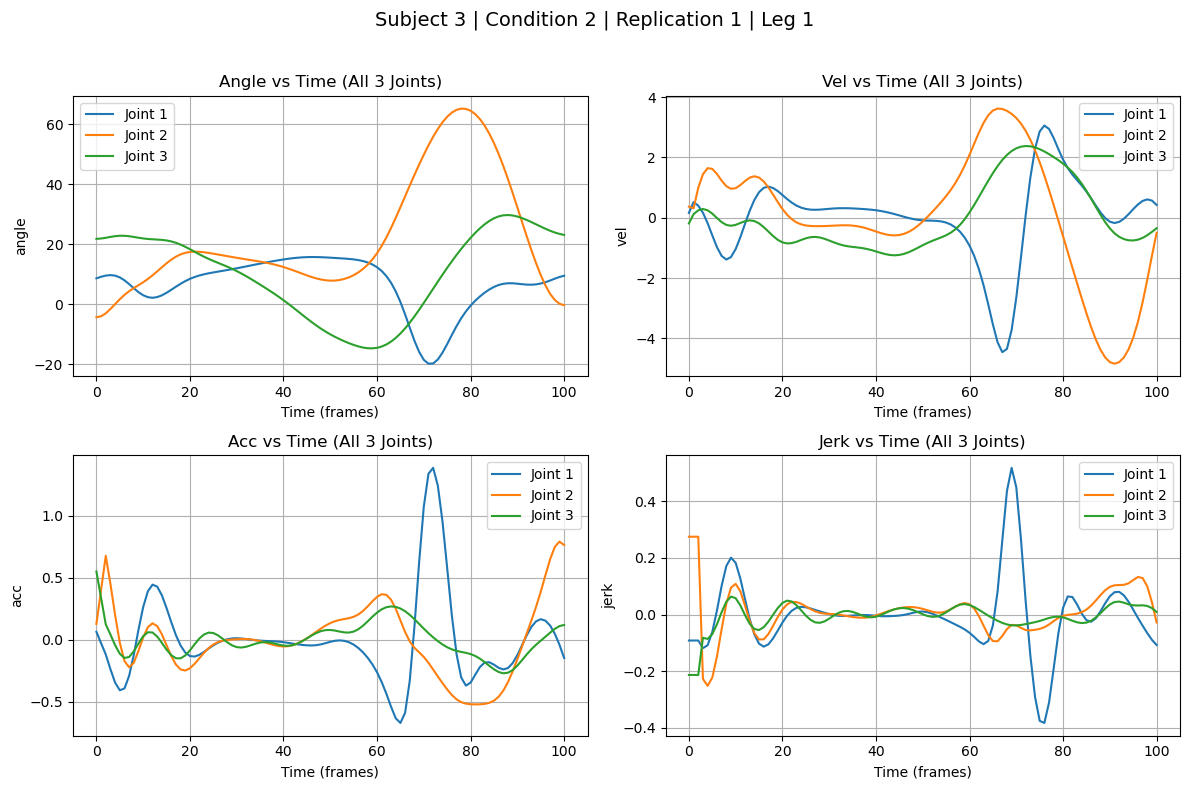

In [35]:
plot_subject(2, 1)
plot_subject(3, 2)

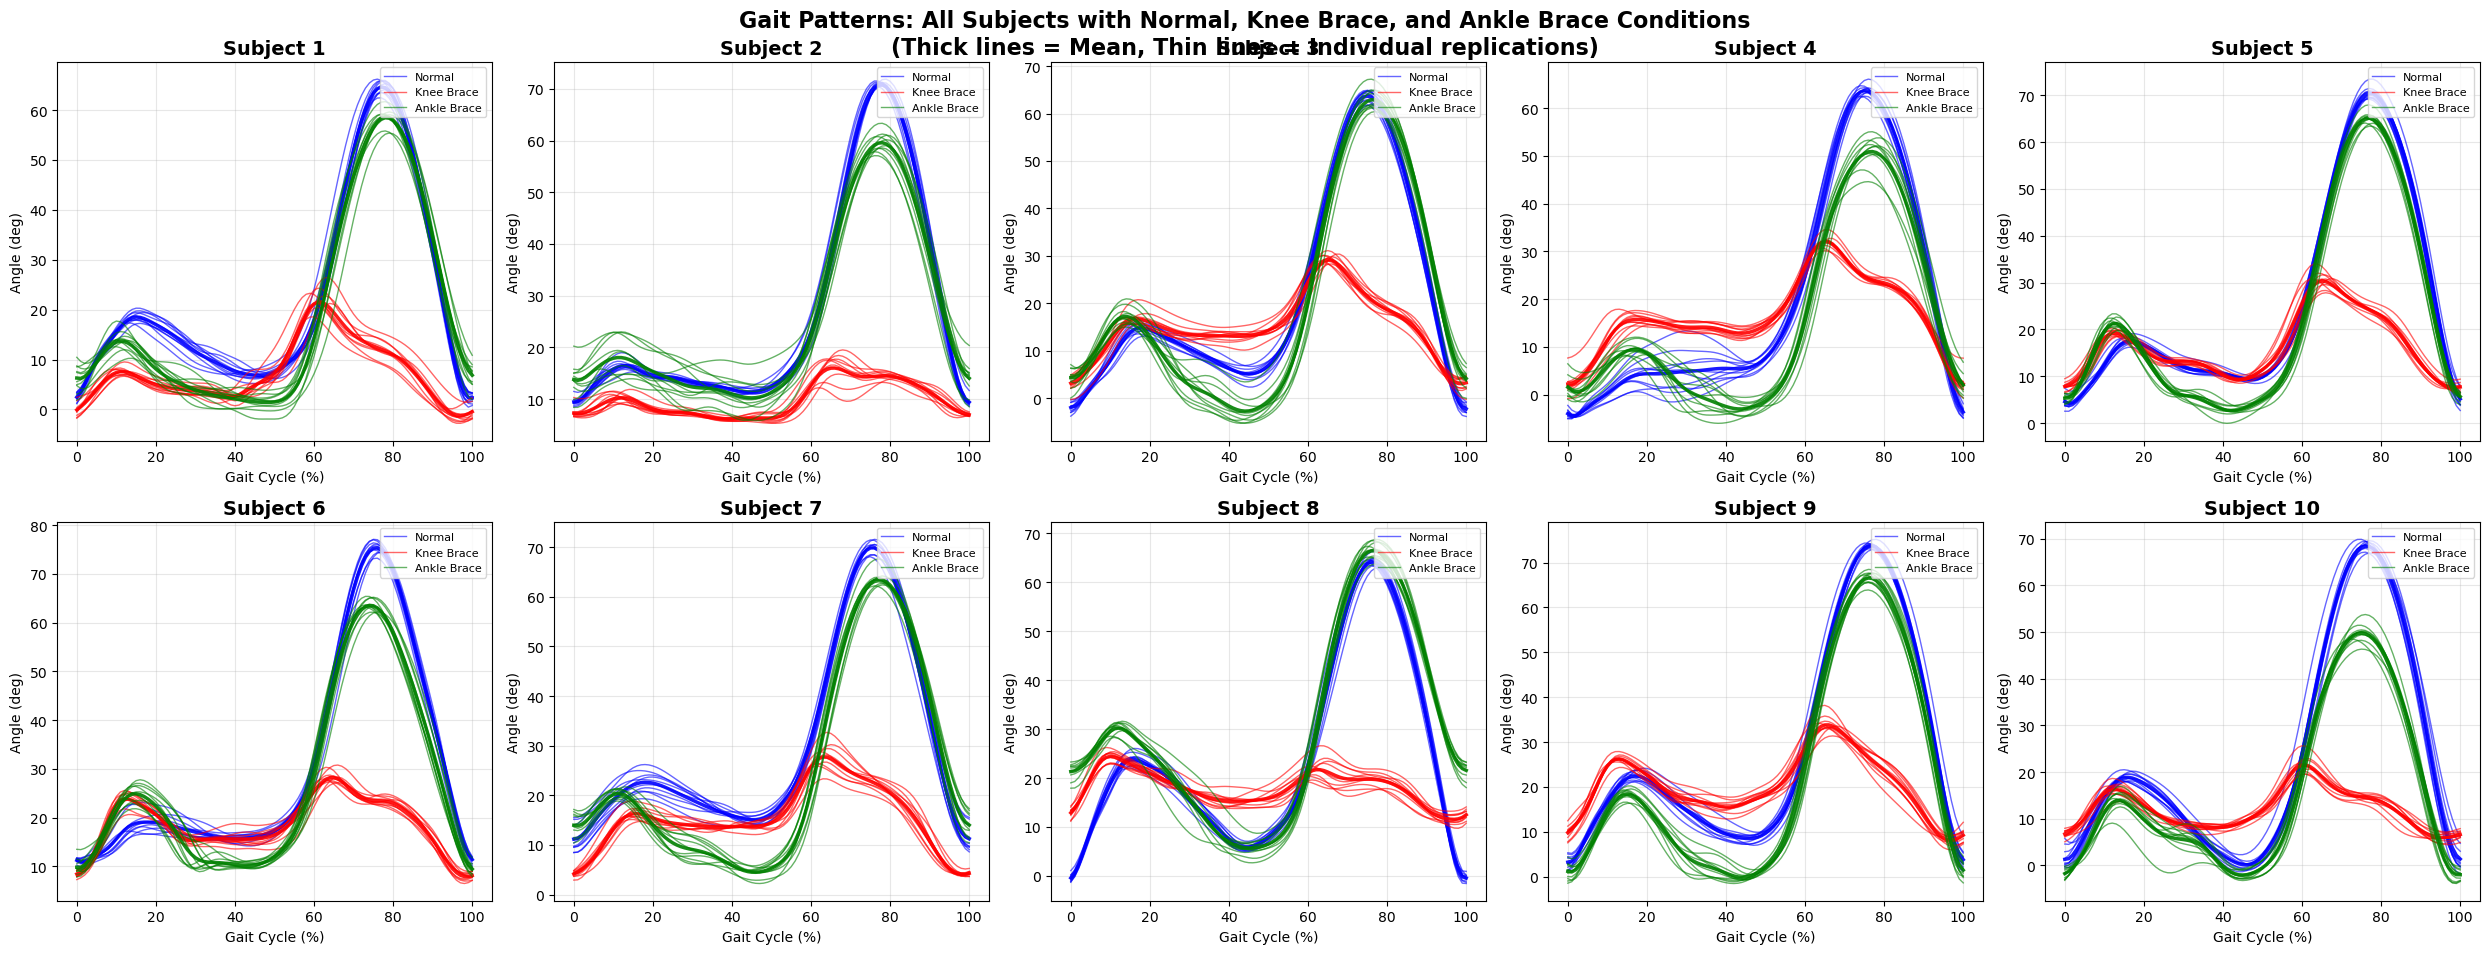

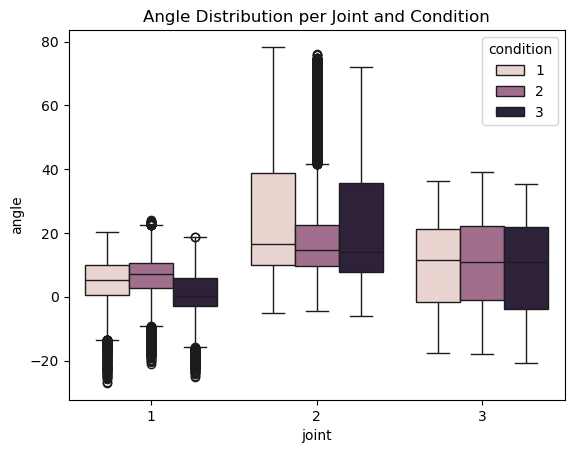

In [36]:
def plot_all_subjects_conditions(data, leg=2, joint=2):
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    axes = axes.flatten()
    conditions = ['Normal', 'Knee Brace', 'Ankle Brace']
    colors = ['blue', 'red', 'green']
    for subject in range(1, 11):
        ax = axes[subject-1]
        for cond_idx, condition in enumerate([1, 2, 3]):
            cycles_data = data[
                (data['subject'] == subject) &
                (data['condition'] == condition) &
                (data['leg'] == leg) &
                (data['joint'] == joint)
            ]
            for rep in range(1, 11):
                rep_data = cycles_data[cycles_data['replication'] == rep].sort_values('time')
                ax.plot(rep_data['time'], rep_data['angle'],
                       color=colors[cond_idx], alpha=0.6, linewidth=1,
                       label=conditions[cond_idx] if rep == 1 else "")
            mean_angle = cycles_data.groupby('time')['angle'].mean()
            if not mean_angle.empty:
                ax.plot(mean_angle.index, mean_angle.values,
                        color=colors[cond_idx], linewidth=2.5, alpha=0.9)
        ax.set_title(f'Subject {subject}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Gait Cycle (%)')
        ax.set_ylabel('Angle (deg)')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', fontsize=8)
    plt.suptitle('Gait Patterns: All Subjects with Normal, Knee Brace, and Ankle Brace Conditions\n(Thick lines = Mean, Thin lines = Individual replications)',
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()

plot_all_subjects_conditions(df)

# Boxplot (joint vs angle per condition)
sns.boxplot(data=df, x='joint', y='angle', hue='condition')
plt.title('Angle Distribution per Joint and Condition')
plt.show()

Visualizing and analysing the graphs above we can observe clear deviations and presence of outliers in sevel joints and at several conditions of the subject.

# Preprocessing
Scaling and Encoding the numerical and the categorical features respectively 

In [37]:
num_cols = ['angle', 'vel', 'acc', 'jerk']

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# One-hot encoding on the leg & joint attributes 
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(df[['leg', 'joint']])
encoded_cols = encoder.get_feature_names_out(['leg', 'joint'])
df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)
df = pd.concat([df, df_encoded], axis=1)

print("Added scaled copies and encoded leg/joint columns. Data shape now:", df.shape)

Added scaled copies and encoded leg/joint columns. Data shape now: (181800, 16)


In [38]:
df.columns

Index(['subject', 'condition', 'replication', 'leg', 'joint', 'time', 'angle',
       'vel', 'acc', 'jerk', 'symmetry_index', 'stability_score', 'gait_score',
       'leg_2', 'joint_2', 'joint_3'],
      dtype='object')

Feature selection for modeling 

In [39]:
feature_cols = []
# numerical features
feature_cols += ['angle', 'vel', 'acc', 'jerk']
# biomechanical features
feature_cols += ['symmetry_index', 'stability_score', 'gait_score']
# encoded categorical features
feature_cols += list(encoded_cols)
# time and replications as numerical features 
feature_cols += ['time', 'replication']
feature_cols += ['subject', 'leg', 'joint']
feature_cols = [c for c in feature_cols if c in df.columns]
print("Number of features used for modeling:", len(feature_cols))

Number of features used for modeling: 15


In [40]:
df.columns

Index(['subject', 'condition', 'replication', 'leg', 'joint', 'time', 'angle',
       'vel', 'acc', 'jerk', 'symmetry_index', 'stability_score', 'gait_score',
       'leg_2', 'joint_2', 'joint_3'],
      dtype='object')

Training and Spliting the data (Subject wise ensuring no data leakage)

In [41]:
train_subjects = [1,2,3,4,5,6,7,8]
test_subjects = [9,10]

train_df = df[df['subject'].isin(train_subjects)].copy()
test_df  = df[df['subject'].isin(test_subjects)].copy()

X_train = train_df[feature_cols]
y_train = np.where(train_df['condition'] == 1, 0, 1)  # 0=Normal, 1=Abnormal
X_test = test_df[feature_cols]
y_test = np.where(test_df['condition'] == 1, 0, 1)

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

X_train shape: (145440, 15) X_test shape: (36360, 15)


# Fitting models: 

Random Forest, SVM(Linear SVC), Logistic regression(probabilistic), Gradient boosting, Ensembling (soft voting)

In [17]:
df.columns

Index(['subject', 'condition', 'replication', 'leg', 'joint', 'time', 'angle',
       'vel', 'acc', 'jerk', 'symmetry_index', 'stability_score', 'gait_score',
       'leg_2', 'joint_2', 'joint_3'],
      dtype='object')

**Random Forest Classifier**


RandomForest Accuracy: 0.7471672167216722


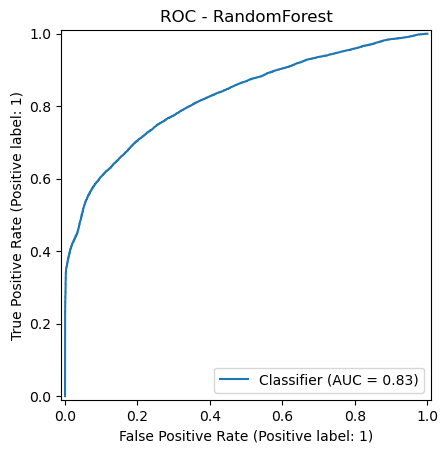

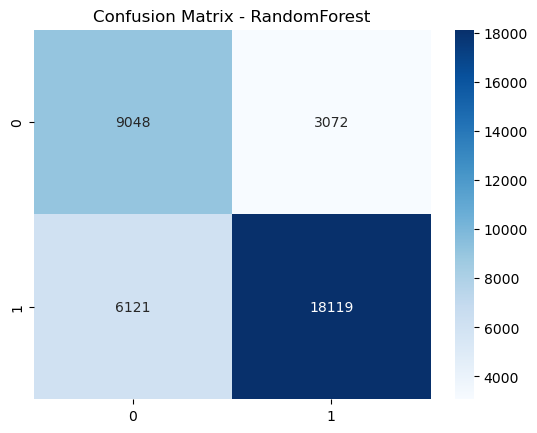

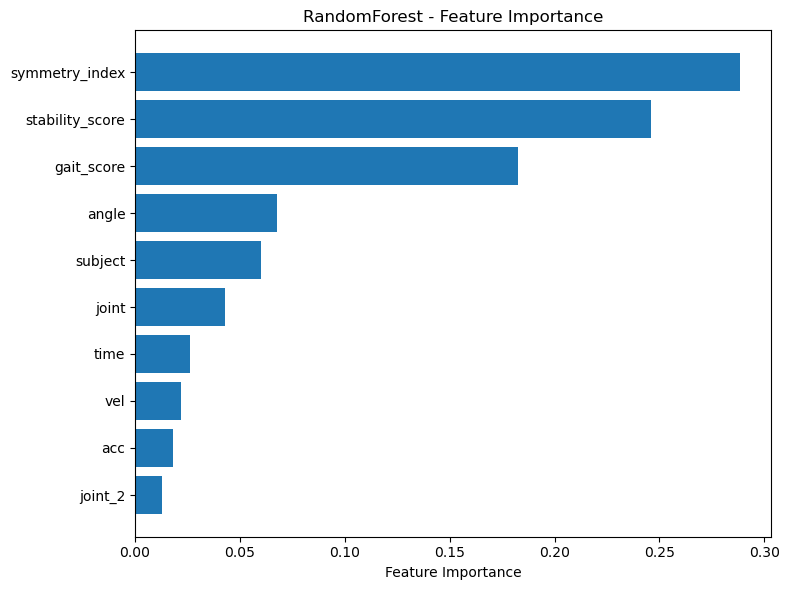

,subject,condition,replication,leg,joint,time,angle,vel,acc,jerk,symmetry_index,stability_score,gait_score,leg_2,joint_2,joint_3
0,1,1,1,1,1,0,-0.465902,0.301872,-1.101286,-0.000023,0.965671,0.403127,68.439908,0.0,0.0,0.0
1,1,1,1,1,1,1,-0.441551,0.301872,-1.101286,-0.000023,0.978959,0.403127,69.104325,0.0,0.0,0.0
2,1,1,1,1,1,2,-0.431776,0.121458,-1.101286,-0.000023,0.983012,0.403127,69.306979,0.0,0.0,0.0
3,1,1,1,1,1,3,-0.440918,-0.112671,-1.427881,-0.947888,0.981905,0.403127,69.251604,0.0,0.0,0.0
4,1,1,1,1,1,4,-0.467804,-0.332299,-1.339710,0.255873,0.982914,0.403127,69.302069,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181795,10,3,10,2,3,96,1.100046,-0.446005,-0.026164,0.784564,0.913699,0.134989,52.434370,1.0,0.0,1.0
181796,10,3,10,2,3,97,1.066921,-0.409515,0.217535,0.707257,0.916779,0.134989,52.588373,1.0,0.0,1.0
181797,10,3,10,2,3,98,1.038803,-0.347539,0.372492,0.449705,0.922136,0.134989,52.856260,1.0,0.0,1.0
181798,10,3,10,2,3,99,1.016089,-0.280662,0.402296,0.086477,0.929648,0.134989,53.231851,1.0,0.0,1.0


In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',      
    class_weight='balanced',   
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]
y_pred_rf = rf_model.predict(X_test)
print("\nRandomForest Accuracy:", accuracy_score(y_test, y_pred_rf))
RocCurveDisplay.from_predictions(y_test, y_prob_rf)
plt.title('ROC - RandomForest')
plt.show()
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - RandomForest')
plt.show()

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  

top_n = 10
top_indices = indices[:top_n]

plt.figure(figsize=(8, 6))
plt.barh(range(top_n), importances[top_indices][::-1])
plt.yticks(range(top_n), X_train.columns[top_indices][::-1])
plt.xlabel("Feature Importance")
plt.title("RandomForest - Feature Importance")
plt.tight_layout()
plt.show()

Accuracy obtained from the random forest model is 74.72.

**SVM (LinearSVC)** 


LinearSVC (baseline) Accuracy: 0.7040979097909791
              precision    recall  f1-score   support

           0       0.74      0.17      0.28     12120
           1       0.70      0.97      0.81     24240

    accuracy                           0.70     36360
   macro avg       0.72      0.57      0.55     36360
weighted avg       0.71      0.70      0.64     36360



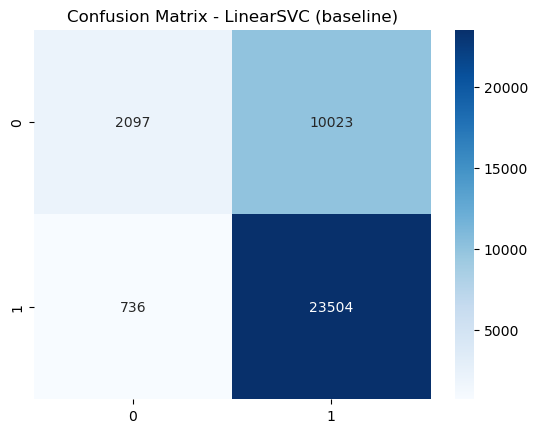

In [ ]:
svm_baseline = make_pipeline(StandardScaler(), LinearSVC(C=1.0, dual=False, max_iter=5000))
svm_baseline.fit(X_train, y_train)
y_pred_svm_baseline = svm_baseline.predict(X_test)
print("\nLinearSVC (baseline) Accuracy:", accuracy_score(y_test, y_pred_svm_baseline))
print(classification_report(y_test, y_pred_svm_baseline))
sns.heatmap(confusion_matrix(y_test, y_pred_svm_baseline), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LinearSVC (baseline)')
plt.show()

SVM (Linear SVC) has accuracy 70.41

**Logistic regression (Probabilistic)**


LogisticRegression Accuracy: 0.7038778877887789


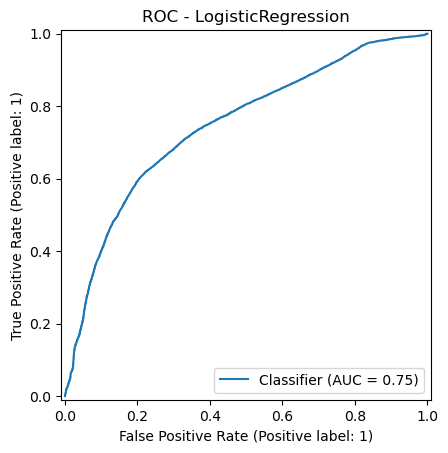

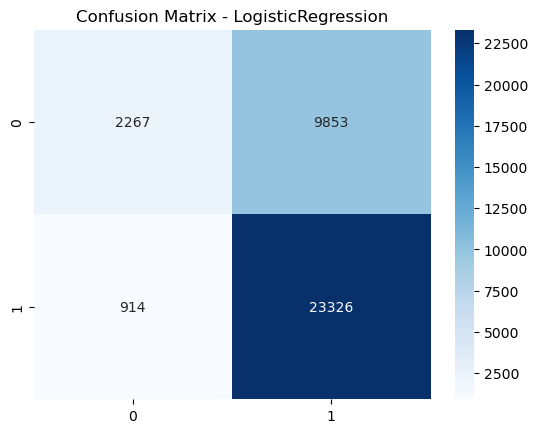

In [ ]:
lr_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
lr_pipeline.fit(X_train, y_train)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:,1]
y_pred_lr = lr_pipeline.predict(X_test)
print("\nLogisticRegression Accuracy:", accuracy_score(y_test, y_pred_lr))
RocCurveDisplay.from_predictions(y_test, y_prob_lr)
plt.title('ROC - LogisticRegression')
plt.show()
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LogisticRegression')
plt.show()

Logistic regression has accuracy 70.39

**Gradient Boosting classifier**


GradientBoosting Accuracy: 0.654015401540154


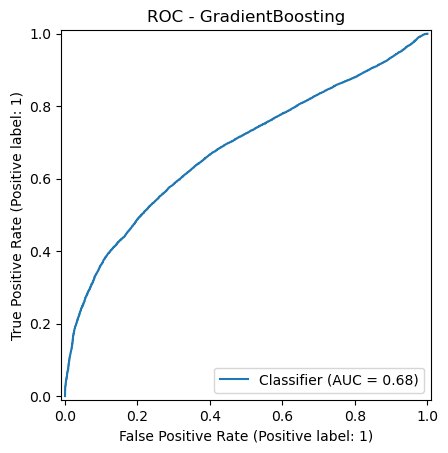

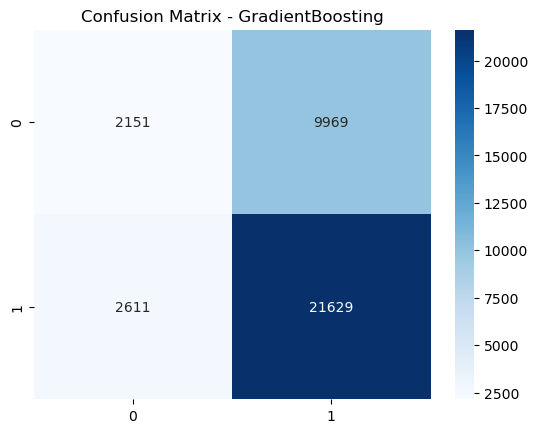

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=1000,       
    learning_rate=0.03,       
    max_depth=6,             
    min_samples_split=4,     
    min_samples_leaf=2,       
    subsample=0.8,            
    max_features='sqrt',      
    random_state=42
)

# Fitting the model 
gb_model.fit(X_train, y_train)

y_prob_gb = gb_model.predict_proba(X_test)[:,1]
y_pred_gb = gb_model.predict(X_test)

# calculating Accuracy
print("\nGradientBoosting Accuracy:", accuracy_score(y_test, y_pred_gb))

RocCurveDisplay.from_predictions(y_test, y_prob_gb)
plt.title('ROC - GradientBoosting')
plt.show()

sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GradientBoosting')
plt.show()

Gradient boosting has the accuracy 65.40

**Ensembling**


Ensemble (hard voting) Accuracy: 0.707948294829483
F1 Score: 0.8046002392124391
ROC-AUC: 0.7847111904878606
              precision    recall  f1-score   support

           0       0.62      0.32      0.42     12120
           1       0.73      0.90      0.80     24240

    accuracy                           0.71     36360
   macro avg       0.67      0.61      0.61     36360
weighted avg       0.69      0.71      0.68     36360



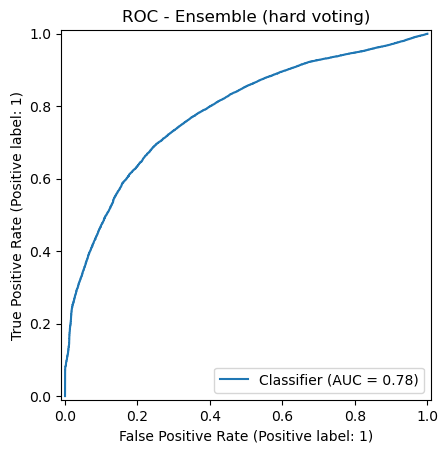

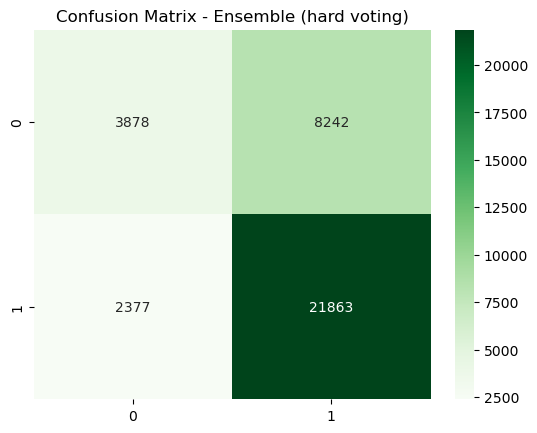

In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_model),
        ('lr', lr_pipeline),
        ('svm', svm_baseline)
    ],
    voting='hard',
    weights=[3, 3, 2, 2],
    n_jobs=-1
)

# Fit ensemble
ensemble.fit(X_train, y_train)

prob_rf  = rf_model.predict_proba(X_test)[:, 1]
prob_gb  = gb_model.predict_proba(X_test)[:, 1]
prob_lr  = lr_pipeline.predict_proba(X_test)[:, 1]

# Convert SVM decision_function to 0–1 scale
svm_scores = svm_baseline.decision_function(X_test)
svm_probs = (svm_scores - svm_scores.min()) / (svm_scores.max() - svm_scores.min())
y_prob_ens = (prob_rf + prob_gb + prob_lr + svm_probs) / 4

y_pred_ens = ensemble.predict(X_test)

# Evaluation
print("\nEnsemble (hard voting) Accuracy:", accuracy_score(y_test, y_pred_ens))
print("F1 Score:", f1_score(y_test, y_pred_ens))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_ens))
print(classification_report(y_test, y_pred_ens))

RocCurveDisplay.from_predictions(y_test, y_prob_ens)
plt.title('ROC - Ensemble (hard voting)')
plt.show()

sns.heatmap(confusion_matrix(y_test, y_pred_ens), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Ensemble (hard voting)')
plt.show()

Above is the ensembling voting classifier with hard voting having the accuracy 70.79

# Summary of all model accuracies

In [45]:
print("\nAccuracy summary")
summary = {
    'RandomForest': accuracy_score(y_test, y_pred_rf),
    'GradientBoosting': accuracy_score(y_test, y_pred_gb),
    'LogisticRegression': accuracy_score(y_test, y_pred_lr),
    'LinearSVC_baseline': accuracy_score(y_test, y_pred_svm_baseline),
    'Ensemble_soft': accuracy_score(y_test, y_pred_ens)
}
for k, v in summary.items():
    print(f"{k:20s}: {v:.4f}")


Accuracy summary
RandomForest        : 0.7472
GradientBoosting    : 0.6540
LogisticRegression  : 0.7039
LinearSVC_baseline  : 0.7041
Ensemble_soft       : 0.7079


# Conclusion: 
Random forest classifier gives the most accuracy out of all models. It shows the accuracy of 74.72 on the test data of subject 9 and 10.